# Unit 9: Discrete Fourier Transform (DFT)

This notebook includes content originally licensed under the MIT License by [Meinard Müller, FAU](https://www.audiolabs-erlangen.de/fau/professor/mueller).
- Original Reference: https://www.audiolabs-erlangen.de/resources/MIR/PCP/PCP_09_dft.html <br>
- Original License: [MIT](https://opensource.org/licenses/MIT)

Modifications in this website licensed under [BSD 3-Clause License](https://github.com/wkCircle/notebooks_articles/blob/main/LICENSE).


<ul> 
    <li><a href='#inner'>Inner Product</a></li>
    <li><a href='#dft'>Definition of DFT</a></li>
    <li><a href='#phase'>DFT Phase</a></li>
    <li><a href='#dftmatrix'>DFT Matrix</a></li>
    <li><a href='#fft'>Fast Fourier Transform (FFT)</a></li>
    <li><a href='#exercise_freq_index'>Exercise 1: Interpretation of Frequency Indices</a></li>
    <li><a href='#exercise_missing_time'>Exercise 2: Missing Time Localization</a></li>    
    <li><a href='#exercise_chirp'>Exercise 3: Chirp Signal</a></li>   
    <li><a href='#exercise_inverse'>Exercise 4: Inverse DFT</a></li>    
</ul>

<a id='inner'></a> 
## Inner Product

In this notebook, we consider discrete-time (DT) signals of finite length $N\in\mathbb{N}$, which we represent as vector 

$$
x=(x(0),x(1),...,x(N-1))^\top\in\mathbb{R}^N
$$ 

with samples $x(n)\in\mathbb{R}^N$ for $n\in[0:N-1]$. Note that $\top$ indicates the transpose of a vector, thus converting a row vector into a column vector. Furthermore, note that we start indexing with the index $0$ (thus adapting our mathematical notation to Python conventions). A general concept for comparing two vectors (or signals) is the **inner product**. Given two vectors $x, y \in \mathbb{R}^N$, the inner product between $x$ and $y$ is defined as follows:

$$ 
\langle x | y \rangle := \sum_{n=0}^{N-1} x(n) y(n).
$$

The absolute value of the inner product may be interpreted as a measure of similarity between $x$ and $y$. If $x$ and $y$  are similar (i.e., if they point to more or less the same direction), the inner product $|\langle x | y \rangle|$ is large. If $x$ and $y$ are dissimilar (i.e., if $x$ and $y$ are more or less orthogonal to each other), the inner product $|\langle x | y \rangle|$ is close to zero.

One can extend this concept to **complex-valued** vectors $x,y\in\mathrm{C}^N$, where the inner product is defined as 

$$
\langle x | y \rangle := \sum_{n=0}^{N-1} x(n) \overline{y(n)}.
$$

In the case of real-valued signals, the complex conjugate does not play any role and the definition of the complex-valued inner product reduces to the real-valued one. In the following code cell, we give some examples.


<strong>Note:</strong>
One can use the NumPy function <code>np.vdot</code> to compute the inner product. However, opposed to the mathematical convention that conjugates the second argument, this function applies complex conjugation on the first argument. Therefore, for computing $\langle x | y \rangle$ as defined above, one has to call <code>np.vdot(y, x)</code>.

In the following, we generate and visualize three signals $x_1$, $x_2$, $x_3$. Then, we compute and discuss different inner products using the signals.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def generate_example_signal(dur=1, Fs=100):
    """Generate example signal

    Source: https://www.audiolabs-erlangen.de/resources/MIR/PCP/PCP_08_signal.html

    Args:
        dur: Duration (in seconds) of signal (Default value = 1)
        Fs: Sampling rate (in samples per second) (Default value = 100)

    Returns:
        x: Signal
        t: Time axis (in seconds)
    """
    N = int(Fs * dur)
    t = np.arange(N) / Fs
    # superimpose 3 different sine waves with different amplitudes
    x = 1 * np.sin(2 * np.pi * (1.9 * t - 0.3))
    x += 0.5 * np.sin(2 * np.pi * (6.1 * t - 0.1))
    x += 0.1 * np.sin(2 * np.pi * (20 * t - 0.2))
    return x, t


def generate_sinusoid(dur=1, amp=1, freq=1, phase=0, Fs=100):
    """Generation of sinusoid

    Source: https://www.audiolabs-erlangen.de/resources/MIR/PCP/PCP_08_signal.html

    Args:
        dur: Duration (in seconds) of sinusoid (Default value = 1)
        amp: Amplitude of sinusoid (Default value = 1)
        freq: Frequency (in Hertz) of sinusoid (Default value = 1)
        phase: Phase (relative to interval [0,1)) of sinusoid (Default value = 0)
        Fs: Sampling rate (in samples per second) (Default value = 100)

    Returns:
        x: Signal
        t: Time axis (in seconds)
    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.sin(2 * np.pi * (freq * t - phase))
    return x, t


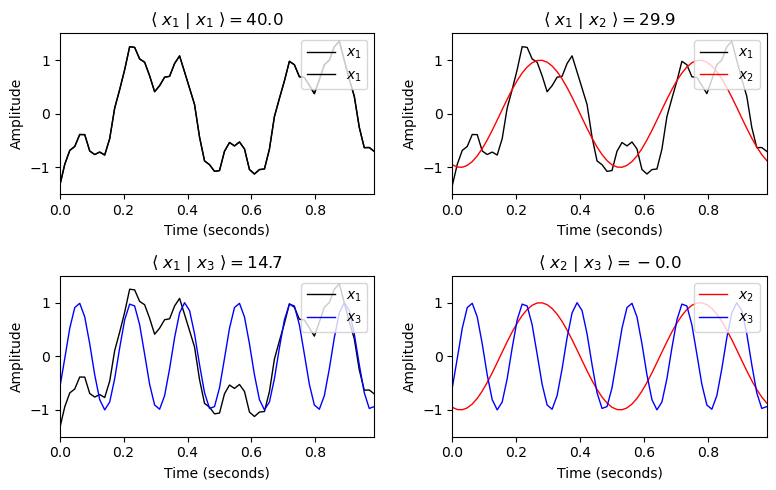

In [2]:


Fs = 64
dur = 1
x1, t = generate_example_signal(Fs=Fs, dur=dur)
x2, t = generate_sinusoid(dur=dur, Fs=Fs, amp=1, freq=2, phase=0.3)
x3, t = generate_sinusoid(dur=dur, Fs=Fs, amp=1, freq=6, phase=0.1)

def plot_inner_product(ax, t, x, y, color_x='k', color_y='r', label_x='x', label_y='y'):
    """Plot inner product

    Notebook: PCP_09_dft.ipynb

    Args:
        ax: Axis handle
        t: Time axis
        x: Signal x
        y: Signal y
        color_x: Color of signal x (Default value = 'k')
        color_y: Color of signal y (Default value = 'r')
        label_x: Label of signal x (Default value = 'x')
        label_y: Label of signal y (Default value = 'y')
    """
    ax.plot(t, x, color=color_x, linewidth=1.0, linestyle='-', label=label_x)
    ax.plot(t, y, color=color_y, linewidth=1.0, linestyle='-', label=label_y)
    ax.set_xlim([0, t[-1]])
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    sim = np.vdot(y, x)
    ax.set_title(r'$\langle$ %s $|$ %s $\rangle = %.1f$' % (label_x, label_y, sim))
    ax.legend(loc='upper right')

plt.figure(figsize=(8, 5))
ax = plt.subplot(2, 2, 1)
plot_inner_product(ax, t, x1, x1, color_x='k', color_y='k', label_x='$x_1$', label_y='$x_1$')
ax = plt.subplot(2, 2, 2)
plot_inner_product(ax, t, x1, x2, color_x='k', color_y='r', label_x='$x_1$', label_y='$x_2$')
ax = plt.subplot(2, 2, 3)
plot_inner_product(ax, t, x1, x3, color_x='k', color_y='b', label_x='$x_1$', label_y='$x_3$')
ax = plt.subplot(2, 2, 4)
plot_inner_product(ax, t, x2, x3, color_x='r', color_y='b', label_x='$x_2$', label_y='$x_3$')
plt.tight_layout()

In the above example, one can make the following observations:

* The signal $x_1$ is similar to itself, leading to a large value of $\langle x_1 | x_1 \rangle=40.0$.
* The overall course of the signal $x_1$ strongly correlates with the sinusoid $x_2$, which is reflected by a relatively large value of $\langle x_1 | x_2 \rangle=29.9$.
* There are some finer oscillations of $x_1$ that are captured by $x_3$, leading to a still noticeable value of  $\langle x_1 | x_3 \rangle=14.7$. 
* The two sinusoids $x_2$ and $x_3$ are more or less uncorrelated, which is revealed by the value of $\langle x_2 | x_3 \rangle\approx 0$. 

In other words, the above comparison reveals that the signal $x_1$ has a strong signal component of $2~\mathrm {Hz}$ (frequency of $x_2$) and $6~\mathrm {Hz}$ (frequency of $x_3$). Measuring correlations between an arbitrary signal and sinusoids of different frequencies is exactly the idea of performing a Fourier (or spectral) analysis. 

<a id='dft'></a> 
## Definition of DFT

Let $x\in \mathbb{C}^N$ be a vector of length $N\in\mathbb{N}$. The **discrete Fourier transform** (DFT) of $x$ is defined by:

$$ \hat{x}_k := \hat{X}(k) := \sum_{n=0}^{N-1} x(n) e^{-2 \pi i k n / N},~\forall~k=0,\cdots,N-1$$

The vector $X\in\mathbb{C}^N$ can be interpreted as a frequency representation of the time-domain signal $x$.   To obtain a geometric interpretation of the DFT, we define the vector $\mathbf{e}_k \in\mathbb{C}^N$ with real part $\mathbf{c}_k=\mathrm{Re}(\mathbf{e}_k)$ and imaginary part $\mathbf{s}_k=\mathrm{Im}(\mathbf{e}_k)$ by

$$\mathbf{e}_k(n) :=  e^{2 \pi i k n / N} = \cos(2 \pi k n / N) + i \sin(2 \pi k n / N)
= \mathbf{c}_k(n) + i \mathbf{s}_k(n),~\forall~k=0,\cdots,N-1$$


This vector can be regarded as a [sampled version](PCP_08_signal.html) of the [exponential function](PCP_07_exp.html) of frequency $k/N$. Using inner products, the DFT can be expressed as

$$ \hat{x}_k = \hat{X}(k) = \sum_{n=0}^{N-1} x(n) \overline{\mathbf{e}_k}(n) = \langle x | \mathbf{e}_k \rangle,$$

thus measuring the similarity between the signal $x$ and the sampled exponential functions $\mathbf{e}_k$. The absolute value $|\hat{X}(k)|$ indicates the degree of similarity between the signal $x$ and $\mathbf{e}_k$. In the case that $x\in \mathbb{R}^N$ is a real-valued vector (which is typically the case for audio signals), we obtain:

$$ 
\hat{X}(k) = \langle x |\mathrm{Re}(\mathbf{e}_k) \rangle - i\langle x | \mathrm{Im}(\mathbf{e}_k) \rangle
= \langle x |\mathbf{c}_k \rangle - i\langle x | \mathbf{s}_k \rangle
$$

The following plot shows an example signal $x$ compared with functions $\overline{\mathbf{e}_k}$ for various frequency parameters $k$. The real and imaginary part of $\overline{\mathbf{e}_k}$ are shown in <font color='red'> red</font> and <font color='blue'> blue</font>, respectively.

<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\c'
C:\Users\wkaic\AppData\Local\Temp\ipykernel_35496\2310783336.py:26: SyntaxWarning: invalid escape sequence '\m'
  linewidth=1.0, linestyle=':', label='$\mathrm{Re}(\overline{\mathbf{u}}_k)$')
C:\Users\wkaic\AppData\Local\Temp\ipykernel_35496\2310783336.py:28: SyntaxWarning: invalid escape sequence '\m'
  linewidth=1.0, linestyle=':', label='$\mathrm{Im}(\overline{\mathbf{u}}_k)$')
C:\Users\wkaic\AppData\Local\Temp\ipykernel_35496\2310783336.py:34: SyntaxWarning: invalid escape sequence '\c'
  linewidth=1.0, linestyle=':', label='$\cos_{k, opt}$')


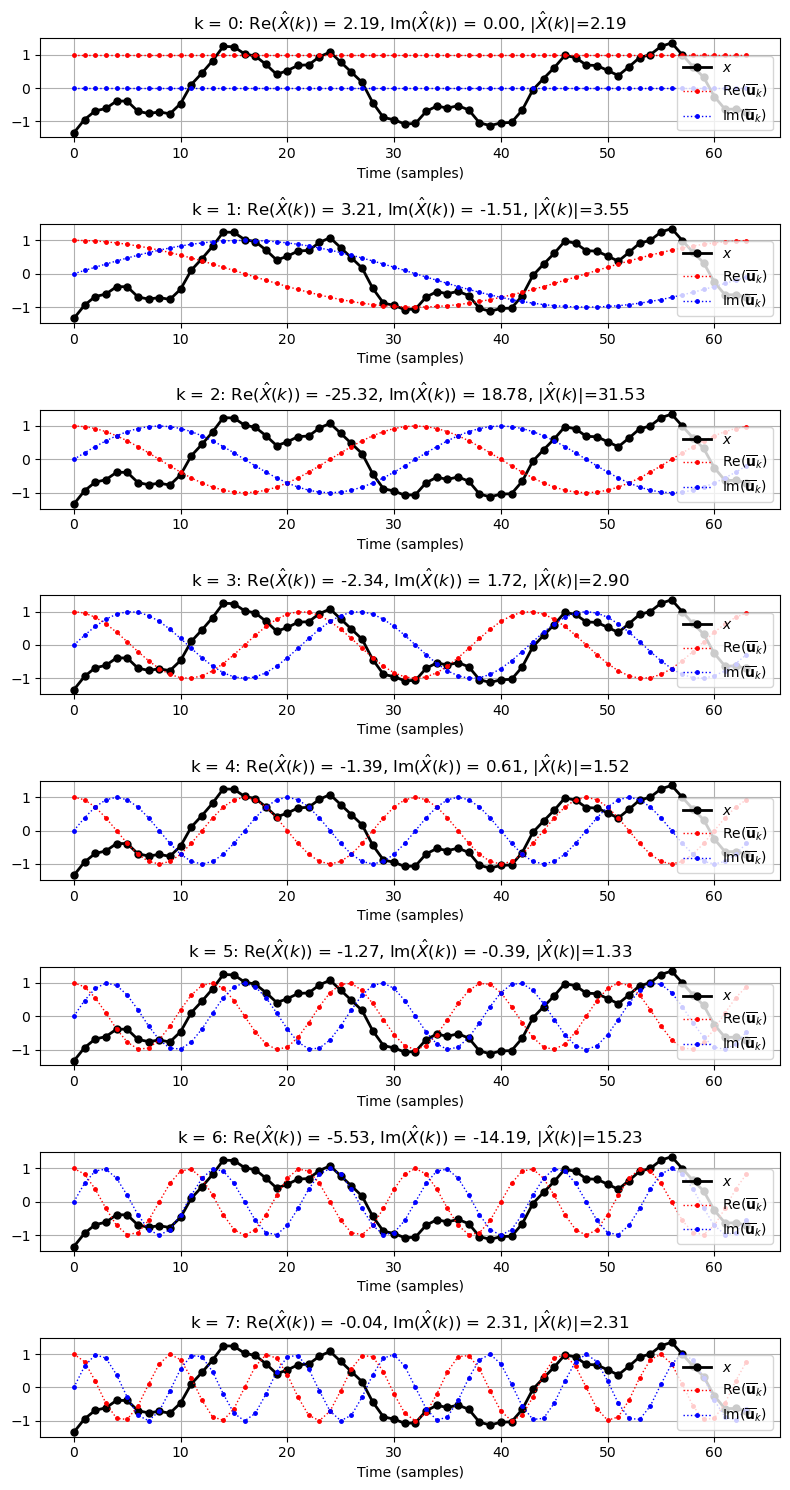

In [3]:
def plot_signal_e_k(ax, x, k, show_e=True, show_opt=False):
    """Plot signal and k-th DFT sinusoid

    Notebook: PCP_09_dft.ipynb

    Args:
        ax: Axis handle
        x: Signal
        k: Index of DFT
        show_e: Shows cosine and sine (Default value = True)
        show_opt: Shows cosine with optimal phase (Default value = False)
    """
    N = len(x)
    time_index = np.arange(N)
    ax.plot(time_index, x, 'k', marker='.', markersize='10', linewidth=2.0, label='$x$')
    plt.xlabel('Time (samples)')
    e_k = np.exp(2 * np.pi * 1j * k * time_index / N)
    x_k = np.real(e_k)
    s_k = np.imag(e_k)
    X_k = np.vdot(e_k, x)

    plt.title(r'k = %d: Re($\hat{X}(k)$) = %0.2f, Im($\hat{X}(k)$) = %0.2f, $|\hat{X}(k)|$=%0.2f' %
              (k, X_k.real, X_k.imag, np.abs(X_k)))
    if show_e is True:
        ax.plot(time_index, x_k, 'r', marker='.', markersize='5',
                 linewidth=1.0, linestyle=':', label='$\mathrm{Re}(\overline{\mathbf{u}}_k)$')
        ax.plot(time_index, s_k, 'b', marker='.', markersize='5',
                 linewidth=1.0, linestyle=':', label='$\mathrm{Im}(\overline{\mathbf{u}}_k)$')
    if show_opt is True:
        phase_k = - np.angle(X_k) / (2 * np.pi)
        cos_k_opt = np.cos(2 * np.pi * (k * time_index / N - phase_k))
        # d_k = np.sum(x * cos_k_opt)
        ax.plot(time_index, cos_k_opt, 'g', marker='.', markersize='5',
                 linewidth=1.0, linestyle=':', label='$\cos_{k, opt}$')
    plt.grid()
    plt.legend(loc='lower right')


N = 64
x, t = generate_example_signal(Fs=N, dur=1)

plt.figure(figsize=(8, 15))
for k in range(0, 8):
    ax = plt.subplot(8, 1, k+1)
    plot_signal_e_k(ax, x, k=k)

plt.tight_layout()

<a id='phase'></a>
## DFT Phase

At first sight, the DFT may be a bit confusing: Why is a real-valued signal $x$ compared with a complex-valued sinusoid $\mathbf{e}_k$? What does the resulting complex-valued Fourier coefficient

$$
\hat{x}_k:= \hat{X}(k) := \langle x |\mathrm{Re}(\mathbf{e}_k) \rangle - i\langle x | \mathrm{Im}(\mathbf{e}_k) \rangle. 
$$

encode? To understand this, we represent the complex number $x_k$ in form of its [polar representation](PCP_06_complex.html#polar)

$$
\hat{x}_k = |\hat{x}_k| \cdot e^{i \theta_k)},    
$$

where $\theta_k$ is the [angle](PCP_06_complex.html) (given in radians), i.e., usually $\theta_k \in [0, 2\pi)$.  Furthermore, let $\mathbf{cos}_{k,\varphi}:[0:N-1]\to\mathbb{R}$ be a sampled sinusoid with frequency parameter $k$ and phase $\varphi\in[0,1)$, defined by

$$
   \mathbf{cos}_{k,\varphi}(n) = \mathrm{cos}\big( 2\pi (\frac{kn}{N} - \varphi) \big), ~\forall n=0,\cdots,N-1
$$

Defining $\varphi_k := - \frac{\theta_k}{2 \pi}$, which is exactly the conversion relationsihp between $\varphi\in[0,1)$ and $\theta_k \in [0, 2\pi)$, one obtains the following remarkable property of the Fourier coefficient $\hat{x}_k$: 

\begin{align}
|\hat{x}_k| &=& \mathrm{max}_{\varphi\in[0,1)} \langle x | \mathbf{cos}_{k,\varphi} \rangle,\\
\varphi_k  &=& \mathrm{argmax}_{\varphi\in[0,1)} \langle x | \mathbf{cos}_{k,\varphi} \rangle.
\end{align}

In other words, the phase $\varphi_k$ maximizes the correlation between $x$ and all possible sinusoids $\mathbf{cos}_{k,\varphi}$ with $\varphi\in[0,1)$. Furthermore, the magnitude $|\hat{x}_k|$ yields this maximal value. Thus, computing a single correlation between $x$ and the complex-valued function $\mathbf{e}_k$ (which real part coincides with $\mathbf{cos}_{k,0}$, and its imaginary part with $\mathbf{cos}_{k,0.25}$, remember that $\varphi=0.25$ is equivalent to $\theta_k=pi/2$, and that $cos(x - 2/pi) = sin(x), x \in \text{Quadrant I}$) solves an optimization problem. In the following code cell, we demonstrate this optimality property, where the $\mathbf{cos}_{k,\varphi}$ with optimal phase $\varphi=\varphi_k$ is shown in <font color='green'>green</font>.

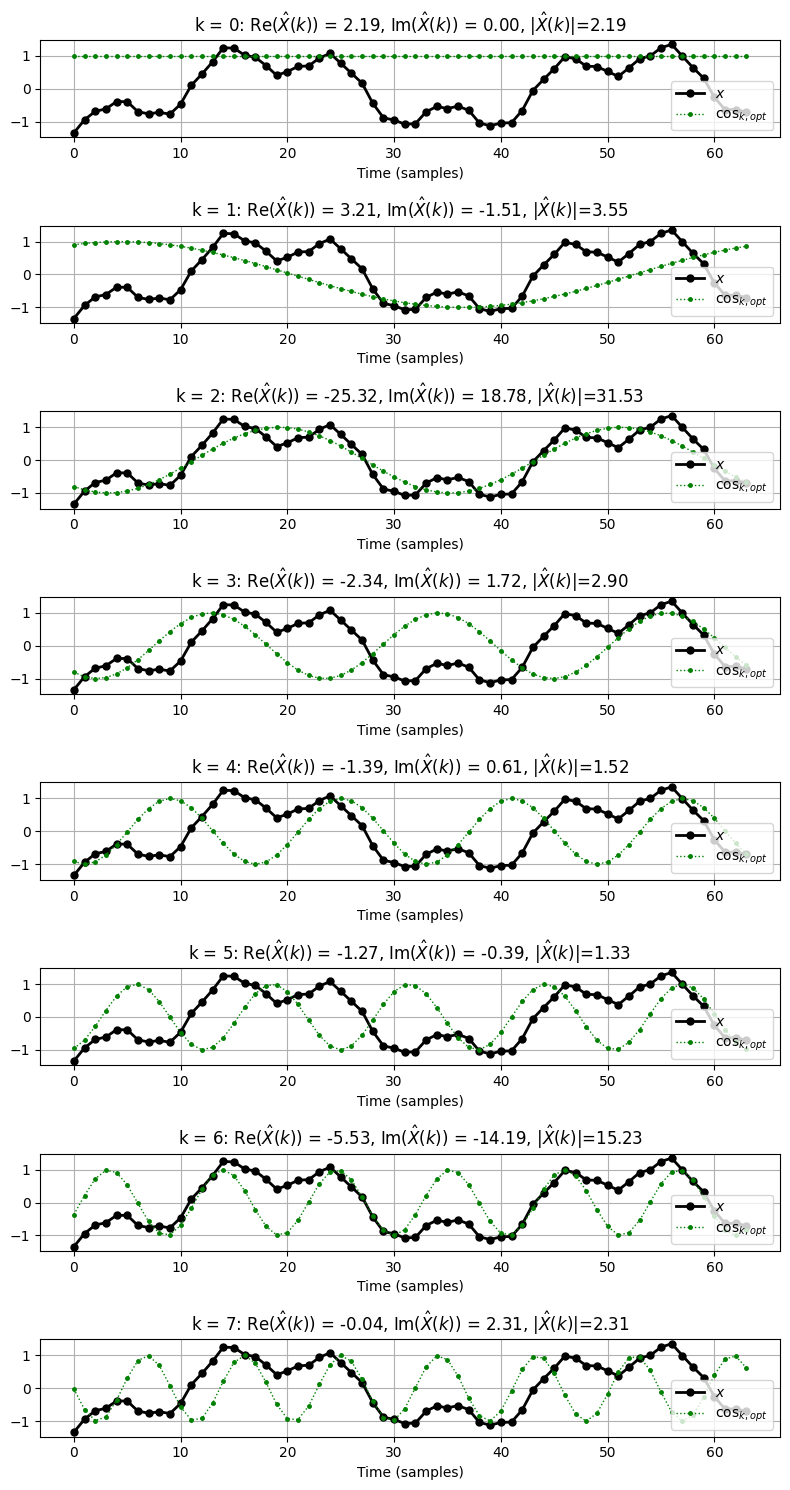

In [7]:
plt.figure(figsize=(8, 15))
for k in range(0, 8):
    ax = plt.subplot(8, 1, k+1)
    plot_signal_e_k(ax, x, k=k, show_e=False, show_opt=True)

plt.tight_layout()

<a id='dftmatrix'></a>
## DFT Matrix

Being a linear operator $\mathbb{C}^N \to \mathbb{C}^N$, the DFT can be expressed by some $N\times N$-matrix. This leads to the famous DFT matrix $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ matrix, which is given by

$$\mathrm{DFT}_N(n, k) = e^{-2 \pi i k n / N}~~~~~~\forall n=0,1,\cdots,N-1,~\text{and}~k=0,1,\cdots,N-1.$$

Let $\sigma_N:= e^{-2 \pi i / N}$ be a primitive $N^\mathrm{th}$ [root of unity](PCP_07_exp.html#roots). Then we can obtain that

$$ \sigma_N^{kn} = (e^{-2 \pi i / N})^{kn} = e^{-2 \pi i k n / N}$$

From this, one obtains:

$$
\mathrm{F}_N =
\begin{pmatrix}
    1 & 1 & 1 & \dots  & 1 \\
    1 & \sigma_N & \sigma_N^2 & \dots  & \sigma_N^{N-1} \\
    1 & \sigma_N^2 & \sigma_N^4 & \dots  & \sigma_N^{2(N-1)} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \sigma_N^{N-1} & \sigma_N^{2(N-1)} & \dots  & \sigma_N^{(N-1)(N-1)} \\
\end{pmatrix}
$$

Note that the $k^\mathrm{th}$ row of $\mathrm{DFT}_N$ corresponds to the vector $\mathbf{e}_k \in \mathbb{C}^N$ as defined above. <br>
In the following visualization, the real and imaginary part of $\mathrm{DFT}_N$ are shown, where the values are encoded by suitable colors.

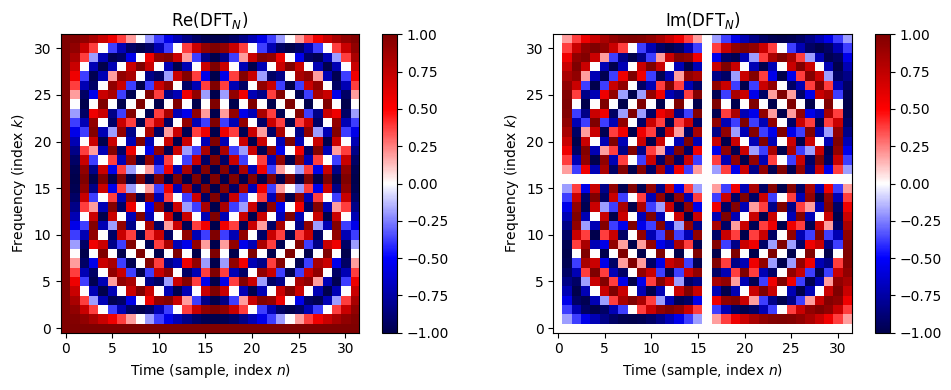

In [5]:
def generate_matrix_dft(K, N):
    """Generate a DFT (discete Fourier transfrom) matrix

    Notebook: PCP_09_dft.ipynb

    Args:
        K: Number of frequency bins
        N: Number of samples

    Returns:
        dft: The DFT matrix
    """
    dft = np.zeros((K, N), dtype=np.complex128)
    time_index = np.arange(N)
    for k in range(K):
        dft[k, :] = np.exp(-2j * np.pi * k * time_index / N)
    return dft

N = 32
dft_matrix = generate_matrix_dft(N, N)

plt.figure(figsize=(10, 4))
for i, (part, func) in enumerate({"Re": np.real, "Im": np.imag}.items(), start=1):
    plt.subplot(1, 2, i)
    plt.title(r'$\mathrm{{{part}}}(\mathrm{{DFT}}_N)$'.format(part=part))
    plt.imshow(func(dft_matrix), origin='lower', cmap='seismic', aspect='equal')
    plt.xlabel('Time (sample, index $n$)')
    plt.ylabel('Frequency (index $k$)')
    plt.colorbar()
    plt.tight_layout()

Now we can apply the matrix $DFT_{N}$ to a given signal $x\in\mathbb{C}^N$ to obtain its discrete fourier transform:

$$
\hat{X}_{N \times 1} := 
\begin{pmatrix}
    \hat{x}_0 \\
    \hat{x}_1 \\
    \vdots \\ 
    \hat{x}_{N-1}
\end{pmatrix}_{N \times 1}
=
\begin{pmatrix}
    e_0 \\
    e_1 \\
    \vdots \\ 
    e_{N-1}
\end{pmatrix}_{N \times N}
\cdot x
=
DFT_{N} \cdot x
$$

The peaks of the magnitude Fourier transform $|X|$ correspond to the main frequency components the signal is composed of. <br>
One can think $X$ as a collection of similarities between $x$ and various $e_k~\forall~k$. <br>
Note that the magnitude Fourier transform is symmetrical around the center. Why? For the interpretation of the time and frequency axis, see also <a href='#exercise_freq_index'>Exercise 1: Interpretation of Frequency Indices</a></li>

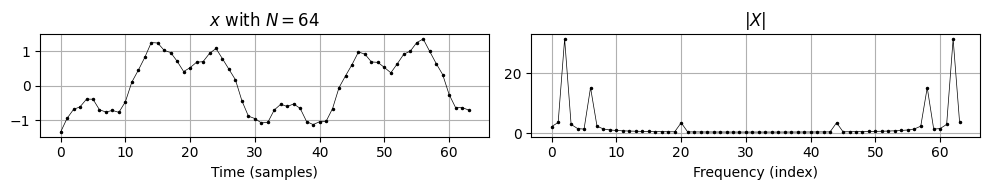

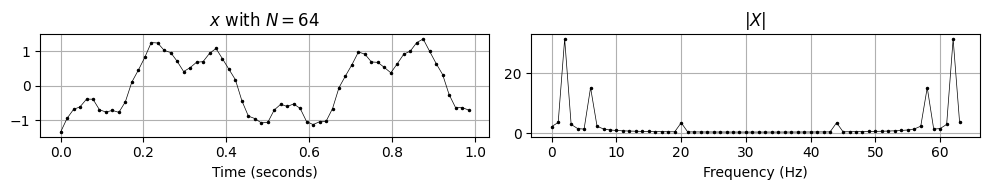

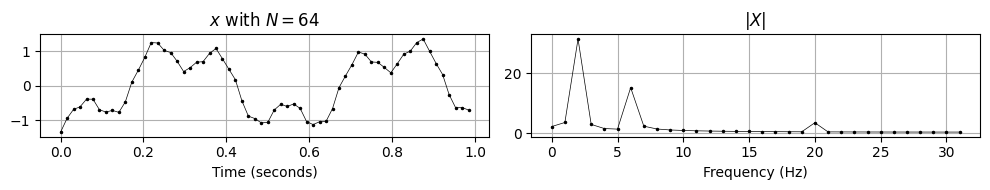

In [6]:
def dft(x):
    """Compute the discete Fourier transfrom (DFT)

    Notebook: PCP_09_dft.ipynb

    Args:
        x: Signal of shape N x 1 to be transformed

    Returns:
        X: Fourier transform of x with shape N x 1
    """
    x = x.astype(np.complex128)
    N = len(x)
    dft_mat = generate_matrix_dft(N, N)
    return np.dot(dft_mat, x)

def plot_signal_dft(t, x, X_hat, ax_sec=False, ax_Hz=False, freq_half=False, figsize=(10, 2)):
    """Plotting function for signals and its magnitude DFT

    Notebook: PCP_09_dft.ipynb

    Args:
        t: Time axis (given in seconds) of length N
        x: Signal of same length as `t`.
        X_hat: DFT of x of shape `len(x) x len(x)`.
        ax_sec: Plots time axis in seconds (Default value = False)
        ax_Hz: Plots frequency axis in Hertz (Default value = False)
        freq_half: Plots only low half of frequency coefficients (Default value = False)
        figsize: Size of figure (Default value = (10, 2))
    """
    N = len(x)
    K = N
    if freq_half is True:
        K = N // 2
        X_hat = X_hat[:K]

    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    ax.set_title('$x$ with $N=%d$' % N)
    if ax_sec is True:
        x_axis = t
        ax.set_xlabel('Time (seconds)')
    else:
        x_axis = range(len(x))
        ax.set_xlabel('Time (samples)')
    ax.plot(x_axis, x, 'k', marker='.', markersize='3', linewidth=0.5)
    ax.grid()

    ax = plt.subplot(1, 2, 2)
    ax.set_title('$|X|$')
    if ax_Hz is True:
        Fs = 1 / (t[1] - t[0])
        x_axis = Fs * np.arange(K) / N
        ax.set_xlabel('Frequency (Hz)')
    else:
        x_axis = range(len(X_hat))
        ax.set_xlabel('Frequency (index)')
    ax.plot(np.abs(X_hat), 'k', marker='.', markersize='3', linewidth=0.5)
    ax.grid()
    plt.tight_layout()
    plt.show()

N = 64
x, t = signal.generate_example_signal(Fs=N, dur=1)
X_hat = dft(x)

plot_signal_dft(t, x, X_hat)
plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True)
plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True, freq_half=True)

<a id='fft'></a>
## Fast Fourier Transform (FFT)

Next, we discuss the famous fast Fourier transform (FFT), which is a fast algorithm to compute the DFT. The FFT algorithm was originally found by Gauss in about 1805 and  then rediscovered by Cooley and Tukey in 1965. The FFT algorithm is based on the observation that applying a DFT of even size $N=2M$ can be expressed in terms of  applying two DFTs of half the size $M$. It exploits the fact that there are algebraic relations between the entries $\sigma_N^{kn} = (e^{-2 \pi i / N})^{kn}$ of DFT matrices. In particular, one has 

$$\sigma_{M}^{kn} = (\sigma_{N}^{kn})^2$$


### One way of thinking
In the FFT algorithm, one computes the DFT of the even-indexed and the uneven-indexed entries of $x$:
$$
\begin{align*}
(A(0), \dots, A(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(0), x(2), x(4), \dots, x(N-2))\\
(B(0), \dots, B(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(1), x(3), x(5), \dots, x(N-1))
\end{align*}
$$

With these two DFTs of size $N/2$, one can compute the full DFT of size $N$ via:

$$
\begin{equation} 

\begin{align*}
C(k) &=& \sigma_N^k \cdot B(k)\\
\hat{X}(k) &=& A(k) + C(k)\\
\hat{X}(\frac{N}{2} + k) &=& A(k) - C(k) &,~~\forall k=0,\cdots,\frac{N}{2}-1\\
\end{align*}
\end{equation}
$$

The numbers $\sigma_N^k$ are also called *twiddle factors*. If $N$ is a power of two, this idea can be applied recursively until one reaches the computation of $\mathrm{DFT}_{1}$ (the case $N=1$), which is simply multiplication by one (i.e. just returning the signal of length $N=1$). For further details, we refer to Section 2.4.3 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015])</a> (see also Table 2.1). 


### Another way of thinking (Cooley–Tukey algorithm, preferred)

Recall $\sigma_N = \exp^{-2 \pi i / N}$. $\sigma_N$ actually has the following property:
- periodicity: $\sigma_N$ has periodicity of N, ie, $\sigma_N^{k+N} = \sigma_N^{k}$
- symmetry: $\sigma_N^{k + \frac{N}{2}} = -\sigma_N^{k}$
- if $m | N$, then $\sigma_N^{mkn} = \sigma_{\frac{N}{m}}^{kn}$

For simplicity, and WLOG, we assume the input signal x has length of power of 2. Even if it's not, we can pad the signal sequence to power of 2 length and apply the FFT algorithm below, which is still faster than DFT.

$$
\begin{equation}
\begin{align*}
\hat{x}_k := \hat{X}(k) &= \sum_n \sigma_N^{kn} \cdot x_n~(~:= F_{N}^{k} \cdot x)\\ 
    &= \sum_{n=2t} \sigma_N^{kn} \cdot x_n + \sum_{n=2t+1} \sigma_N^{kn} \cdot x_n  \\
    &= \sum_{t} \sigma_{\frac{N}{2}}^{kt} \cdot x_{2t} + \sigma_{N}^{k} \sum_{t} \sigma_{\frac{N}{2}}^{kt} \cdot x_{2t + 1} \\
    &= F_{\frac{N}{2}}^{k} \cdot x_{even} + \sigma_{N}^{k} F_{\frac{N}{2}}^{k} \cdot x_{odd}
\end{align*}
\tag 2
\end{equation}
$$
where $F_{\frac{N}{2}}^{k}$ is the fourier transform of row k (freq k) with half periodicity $\frac{N}{2}$ that is applied on the input signals $\{x_n\}_{n=odd}$, $\{x_n\}_{n=even}$ respecitvely.
Based on the unity root property describe above, one also obtains the formula for $\hat{x}_{k + \frac{N}{2}}$:
$$
\begin{equation}
\hat{x}_{k + \frac{N}{2}} = F_{\frac{N}{2}}^{k} \cdot x_{even} - \sigma_{N}^{k} F_{\frac{N}{2}}^{k} \cdot x_{odd}
\tag 3
\end{equation}
$$

From the above equations, it is not hard to see its recursive nature, and we can put them in the matrix form as well: <br>
Define $F_N$ as $\{F_N^{k}\}_{k=0}^{N-1}$ stacked row-wisely.
$$
\begin{equation}
\hat{x}_{N \times 1} = 
\begin{pmatrix}
    \hat{x}_0 \\
    \hat{x}_1 \\
    \vdots \\
    \hat{x}_{N-1} \\
\end{pmatrix}
=
F_N \cdot x_{N \times 1}
=
\begin{bmatrix}
    I_{\frac{N}{2}} & D_{\frac{N}{2}} \\ 
    I_{\frac{N}{2}} & -D_{\frac{N}{2}} \\ 
\end{bmatrix}_{N \times N}
\begin{bmatrix}
    F_{\frac{N}{2}} & O \\ 
    O & F_{\frac{N}{2}} \\ 
\end{bmatrix}_{N \times N}
\begin{bmatrix}
    \begin{pmatrix}
        x_{even} \\
    \end{pmatrix} \\ 
    \begin{pmatrix}
        x_{odd} \\
    \end{pmatrix} \\
\end{bmatrix}_{N \times 1}

\text{, where }
D_{\frac{N}{2}} = 
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 \\ 
0 & \sigma_{\frac{N}{2}} & 0 & \cdots & 0 \\ 
0 & 0 & (\sigma_{\frac{N}{2}})^{2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
0 & 0 & 0 & \cdots & (\sigma_{\frac{N}{2}})^{\frac{N}{2}-1} \\
\end{bmatrix}_{\frac{N}{2} \times \frac{N}{2}}

\tag 4
\end{equation}
$$

Important references for understaning Cooley-Tukey FFT Algorithm:
- [Youtube- Schenelle FFT](https://www.youtube.com/watch?v=HFlIIIi5cEM): provides visualization for sketch of proof
- [Wiki ZH-TW FFT](https://zh.wikipedia.org/zh-tw/%E5%BF%AB%E9%80%9F%E5%82%85%E9%87%8C%E5%8F%B6%E5%8F%98%E6%8D%A2): provides simple sketch of proof
- [Cooley–Tukey FFT algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm): provides proof and pseudocode



#### Example
Assume $x \in \mathbb{R}^8$, ie, case $N=8$, <br>
$$
F_8 \cdot x = 
\begin{bmatrix}
    I_{4} & D_{4} \\ 
    I_{4} & -D_{4} \\ 
\end{bmatrix}
\begin{bmatrix}
    F_{4} & O \\ 
    O & F_{4} \\ 
\end{bmatrix}
\begin{bmatrix}
    \begin{pmatrix}
        x_{0} \\
        x_{2} \\
        x_{4} \\
        x_{6} \\
    \end{pmatrix} \\ 
    \begin{pmatrix}
        x_{1} \\
        x_{3} \\
        x_{5} \\
        x_{7} \\
    \end{pmatrix} \\
\end{bmatrix}_{N \times 1}
$$
Applying the algorithm again (notice that we take even and odd indices again):
$$
F_{4} \cdot 
\begin{pmatrix}
    x_{0} \\
    x_{2} \\
    x_{4} \\
    x_{6} \\
\end{pmatrix}
= 
\begin{bmatrix}
    I_{2} & D_{2} \\ 
    I_{2} & -D_{2} \\ 
\end{bmatrix}
\begin{bmatrix}
    F_{2} & O \\ 
    O & F_{2} \\ 
\end{bmatrix}
\begin{bmatrix}
    \begin{pmatrix}
        x_{0} \\
        x_{4} \\
    \end{pmatrix} \\ 
    \begin{pmatrix}
        x_{2} \\
        x_{6} \\
    \end{pmatrix} \\
\end{bmatrix}
$$
$$
F_{4} \cdot 
\begin{pmatrix}
    x_{1} \\
    x_{3} \\
    x_{5} \\
    x_{7} \\
\end{pmatrix}
= 
\begin{bmatrix}
    I_{2} & D_{2} \\ 
    I_{2} & -D_{2} \\ 
\end{bmatrix}
\begin{bmatrix}
    F_{2} & O \\ 
    O & F_{2} \\ 
\end{bmatrix}
\begin{bmatrix}
    \begin{pmatrix}
        x_{1} \\
        x_{5} \\
    \end{pmatrix} \\ 
    \begin{pmatrix}
        x_{3} \\
        x_{7} \\
    \end{pmatrix} \\
\end{bmatrix}
$$

### DFT vs FFT
DFT requires $\mathcal{O}(n^2)$ time complexity, whereas FFT requires only $\mathcal{O}(n\log_2 n)$.

### Move on 
In the following code, we provide a function `fft` that implements the FFT algorithm. We test the function  `fft` by comparing its output with the one when applying the `dft` on a test signal `x`. For the comparison of result matrices, we use the NumPy functions [`np.array_equal`](https://numpy.org/doc/stable/reference/generated/numpy.array_equal.html) and [`np.allclose`](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html#numpy.allclose).


In [ ]:
def fft(x):
    """Compute the fast Fourier transform (FFT) recursively.

    Notebook: PCP_09_dft.ipynb

    Args:
        x: Signal to be transformed

    Returns:
        X_hat: Fourier transform of x
    """
    x = x.astype(np.complex128)
    N = len(x)
    assert np.log2(N) == int(np.log2(N)), 'N must be a power of two!'
    X_hat = np.zeros(N, dtype=np.complex128)

    if N == 1:
        return x
    else:
        this_range = np.arange(N)
        A = fft(x[this_range % 2 == 0])
        B = fft(x[this_range % 2 == 1])
        range_twiddle_k = np.arange(N // 2)
        sigma = np.exp(-2j * np.pi * range_twiddle_k / N)
        C = sigma * B
        X_hat[:N//2] = A + C
        X_hat[N//2:] = A - C
        return X_hat
    
N = 64
x, t = signal.generate_example_signal(Fs=N, dur=1)

X_via_dft = dft(x)
X_via_fft = fft(x)
X_via_fft_numpy = np.fft.fft(x)

is_equal = np.array_equal(X_via_dft, X_via_fft)
is_equal_tol = np.allclose(X_via_dft, X_via_fft)
is_equal_tol_np = np.allclose(X_via_dft, X_via_fft_numpy)

print('Equality test for dft(x) and fft(x) using np.array_equal:    ', is_equal)
print('Equality test for dft(x) and fft(x) using np.allclose:       ', is_equal_tol)
print('Equality test for dft(x) and np.fft.fft(x) using np.allclose:', is_equal_tol_np)

Equality test for dft(x) and fft(x) using np.array_equal:     False
Equality test for dft(x) and fft(x) using np.allclose:        True
Equality test for dft(x) and np.fft.fft(x) using np.allclose: True


<div class="alert alert-block alert-warning">
<strong>Note:</strong> The test shows that our <code>dft</code> and <code>fft</code> implementations do not yield the same result (due to numerical issues). However, the results are numerically very close, which is verified by the test using <code>np.allclose</code>.  
</div>

The FFT reduces the overall number of operations from the order of $N^2$ (needed when computing the usual matrix&ndash;vector product $\mathrm{DFT}_N \cdot x$) to the order of $N\log_2N$. The savings are enormous. For example, using $N=2^{10}=1024$, the FFT requires roughly $N\log_2N=10240$ instead of $N^2=1048576$ operations in the naive approach. Using the module `timeit`, which provides a simple way to time small bits of Python code, the following code compares the running time when using the naive approach and the FFT. Furthermore, we compare the running time with the highly optimized NumPy implementation <code>np.fft.fft</code>.

In [ ]:
import timeit

rep = 3
for N in [256, 512, 1024, 2048, 4096]:
    time_index = np.arange(N)
    x = np.sin(2 * np.pi *  time_index / N )
    t_DFT = 1000 * timeit.timeit(lambda: dft(x), number=rep)/rep
    t_FFT = timeit.timeit(lambda: fft(x), number=rep*5)/(rep*5)
    t_FFT_np = timeit.timeit(lambda: np.fft.fft(x), number=rep*100)/(rep*100)
    print(f'Runtime (ms) for N = {N:4d} : DFT {t_DFT:10.2f},  FFT {t_FFT:.5f},  FFT_np {t_FFT_np:.8f}')

Runtime (ms) for N =  256 : DFT       3.89,  FFT 0.00292,  FFT_np 0.00000333
Runtime (ms) for N =  512 : DFT      12.04,  FFT 0.00584,  FFT_np 0.00000440
Runtime (ms) for N = 1024 : DFT      47.19,  FFT 0.01162,  FFT_np 0.00000721
Runtime (ms) for N = 2048 : DFT     174.00,  FFT 0.02309,  FFT_np 0.00001566
Runtime (ms) for N = 4096 : DFT     690.02,  FFT 0.04761,  FFT_np 0.00002668


## Exercises and Results

<a id='exercise_freq_index'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 1: Interpretation of Frequency Indices</strong><br>

Given a dimension $N\in\mathbb{N}$, the $\mathrm{DFT}_N$ transform a vector $x\in\mathbb{C}^N$ into another vector $X\in\mathbb{C}^N$. Assuming that $x$ represents a time-domain signal sampled with a sampling rate $F_\mathrm{s}$, one can associate the index $n\in[0:N-1]$ of the sample $x(n)$ with the physical time point $t = n/F_\mathrm{s}$ given in seconds. In case of the vector $X$, the index $k\in[0:N-1]$ of the coefficient $X(k)$ can be associated to a physical frequency value 

$$
  f=\frac{k \cdot F_\mathrm{s}}{N}.
$$
    
Furthermore, using a real-valued signal $x\in\mathbb{R}^N$, the upper part of $X\in\mathbb{C}^N$ becomes redundant, and it suffices to consider the first $K$ coefficients with $K=N/2$.
    
<ul>
<li>Find explanations why these properties apply.</li>
<li>Find out how the function <code>plot_signal_dft</code> uses these properties to convert and visualize the time and frequency axes.</li>   
<li>Using the signal <code>x, t = libpcp.signal.generate_example_signal(Fs=64, dur=2)</code>, plot the signal and its magnitude Fourier transform once using axes given in indices and once using axes given in physical units (seconds, Hertz). Discuss the results.</li>
<li>Do the same for the signal <code>x, t = libpcp.signal.generate_example_signal(Fs=32, dur=2)</code>. What is going wrong and why?</li>  
</ul>
</div>

- sampling rate $F_s$ means that we sample $F_s$ points per second, therefore for a vector $x$ of shape N. It contains N points, and therefore of $N/F_s$ seconds. The relationship between index $n$ and time point $t$ is of course $t=n/F_s$. As for the frequency, Fourier transform says that $\hat{x}_k = \hat{X}(k) = \int_{0}^{N} x(n) \cdot e^{-2\pi i (k /N)n}dn$, which means that on the unit circle it rotates $k/N$ for every change of $n$, ie, $\frac{d P(t)}{dn} = k / N$, where $P$ is the movement based on time. Therefore, if we change to per time change, then it becomes $f = \frac{dP(t)}{dt} = \frac{dP(t)}{dn} \frac{dn}{dt} = k \cdot F_s / N$.
- When $x$ is real valued, we have the theorem, DFT conjugate symmetry [DST Ch 6.3](https://brianmcfee.net/dstbook-site/content/ch06-dft-properties/Conjugate-Symmetry.html), that $\hat{x}_k = \overline{\hat{x}_{N-k}} \forall~k$. Therefore, we only need to compute cases where $k=0,\cdots, (N-1)/2$, and the other half k's will just have same real part values but the changed sign imagniary part values (ie, conjugate). This saves 50% efficiency for computation.
- the function `plot_signal_dft` provides the argument `freq_half` that, when it is true, the plot will only show half the frequency by considering only the first half of $\hat{X}$ with corresponding $k=0,\cdots,(N-1)/2$. Besides, the function plots the absolute value of the fourier transformed signal of $x$. The reason why it is symmetric on the middle freq is again becuase of the conjuagte symmetry theorem of real-valued signals, and that $|\hat{x}_k| = |\overline{\hat{x}_k}| \forall~k$.


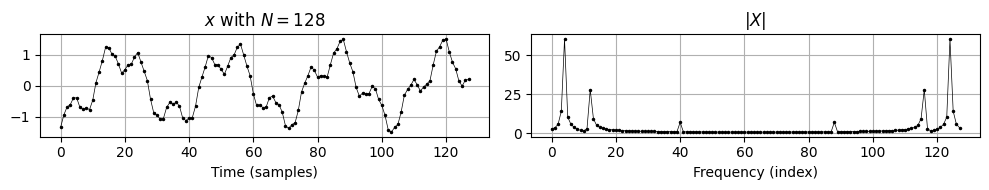

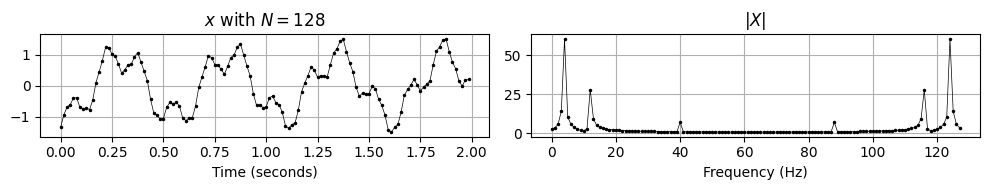

In [15]:
x, t = signal.generate_example_signal(Fs=64, dur=2)
X_hat = dft(x)

plot_signal_dft(t, x, X_hat)
plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True)

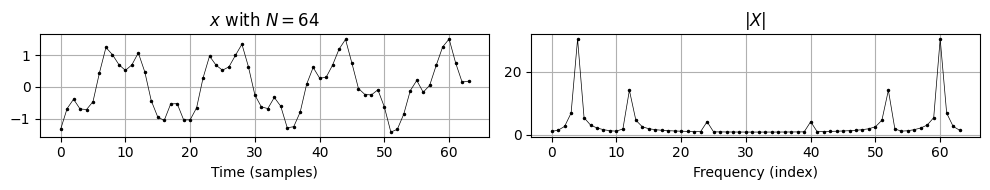

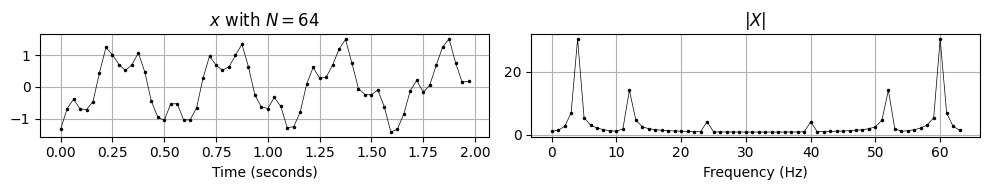

In [16]:
x, t = signal.generate_example_signal(Fs=32, dur=2)
X_hat = dft(x)

plot_signal_dft(t, x, X_hat)
plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True)

<a id='exercise_missing_time'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 2: Missing Time Localization</strong><br>

The Fourier transform yields frequency information that is averaged over the entire time axis. However, the information on when these frequencies occur is hidden in the transform. To demonstrate this phenomenon, construct the following two different signals defined on a common time axis $[0, T]$ with $T$ given in seconds (e.g., $T=6~\mathrm{sec}$). 

- A superposition of two sinusoids $f_1+f_2$ defined over the entire time interval $[0, T]$, where the first sinusoid $f_1$ has a frequency $\omega_1=1~\mathrm{Hz}$ and an amplitude of $1$, while the second sinusoid $f_2$ has a frequency $\omega_2=5~\mathrm{Hz}$ and an amplitude of $0.5$.
- A concatenation of two sinusoids, where $f_1$ (specified as before) is now defined only on the subinterval $[0, T/2]$, and $f_2$ is defined on the subinterval $[T/2, T]$.
    
Sample the interval $[0,T]$ to obtain $N$ samples (use <code>np.linspace</code>), with $N\in\mathbb{N}$ being power of two (e.g., $N=256$). Define DT-signals of the superposition and the concatenation and compute the DFT for each of the signals. Plot the signals as well as the resulting magnitude Fourier transforms and discuss the result.
</div>

Fourier transform consider the entire singal $x$, tries to correlate it with sine waves of various frequencies, and record the correlations/similarities. Therefore, when signal changes suddenly like in the second case (with concat), fourier fails to detect it with still the frequency that has the highest similarity among the whole signal.

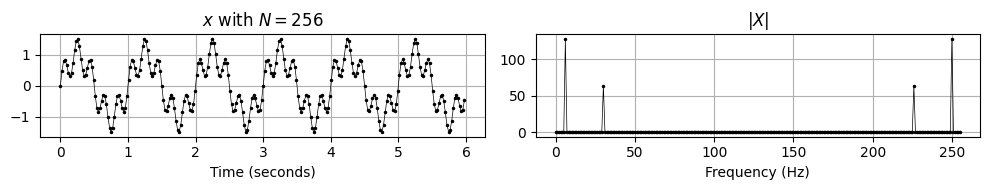

In [23]:
T = 6
f1, _ = signal.generate_sinusoid(dur=T, amp=1, freq=1, Fs=128/3)
f2, t = signal.generate_sinusoid(dur=T, amp=0.5, freq=5, Fs=128/3)
x = f1 + f2
X_hat = dft(x)

plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True)

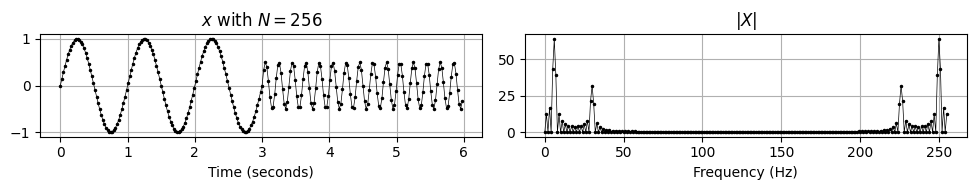

In [27]:
T = 6
f1, t1 = signal.generate_sinusoid(dur=T/2, amp=1, freq=1, Fs=128/3)
f2, t2 = signal.generate_sinusoid(dur=T/2, amp=0.5, freq=5, Fs=128/3)
x = np.append(f1, f2)
X_hat = dft(x)

plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True)

To recover the hidden time information where signal suddenly changes freq. We may use short-time Fourier transform (STFT) with a given time window and apply the fourier transform only on that window of signals. Then we shift the window and repeat the process. Finally we get a collection of spectrums (one spectrum is just like the $|X|$ plot generated as the 2nd figure in the func `plot_signal_dft`)

<a id='exercise_chirp'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 3: Chirp Signal</strong><br>

The function $f(t)=\sin\left(\pi t^2\right)$ defines a <strong>chirp signal</strong> (also called <strong>sweep signal</strong>), in which the frequency increases with time. The <strong>instantaneous frequency</strong> $\omega_t$ of the chirp signal at time $t$ is the derivate of the sinusoid's argument divided by $2\pi$, thus $\omega_t = t$. 

- Let $[t_0,t_1]$ be a time interval (given in seconds) with $0\leq t_0<t_1$ and $N\in\mathbb{N}$ be power of two. Implement a function <code>generate_chirp</code> that outputs a sampled chirp signal <code>x</code> over the interval $[t_0,t_1]$ with $N$ samples (use <code>np.linspace</code>).
- Compute the DFT of <code>x</code> for various input parameters $t_0$, $t_1$, and $N$. Plot the chirp signal as well as the resulting magnitude Fourier transform. Discuss the result.

changes from t0
case t0=0


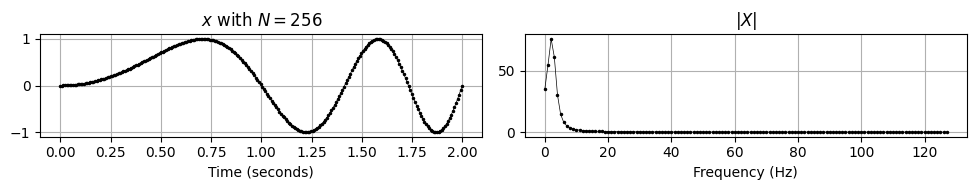

case t0=0.5


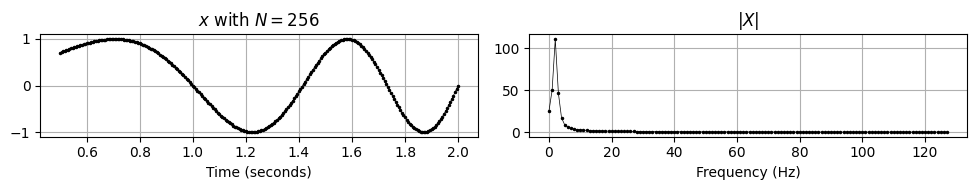

case t0=1


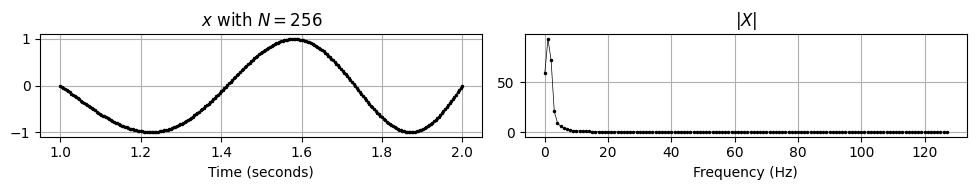

changes from t1
case t1=2


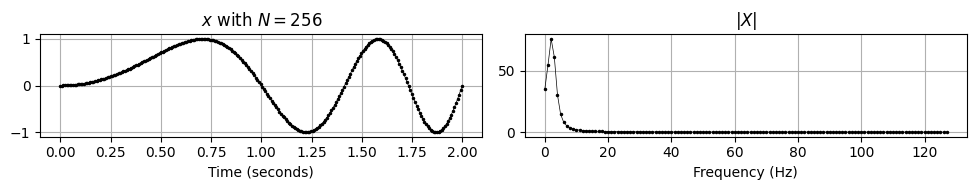

case t1=8


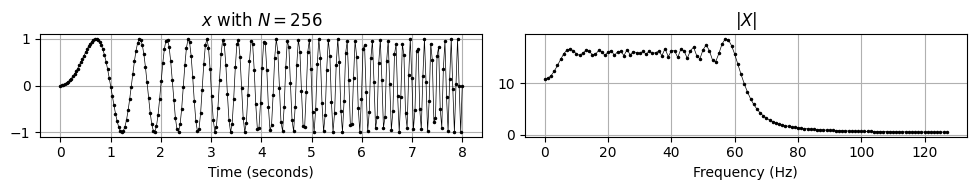

case t1=32


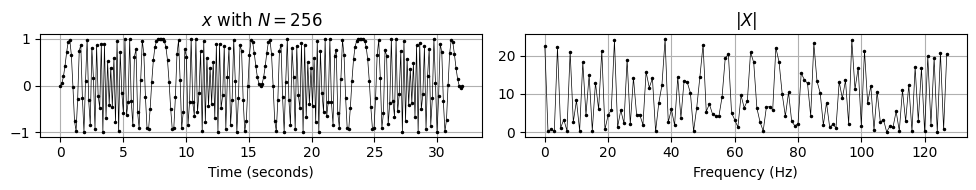

changes from N


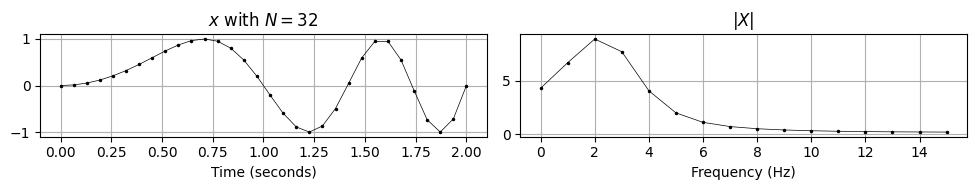

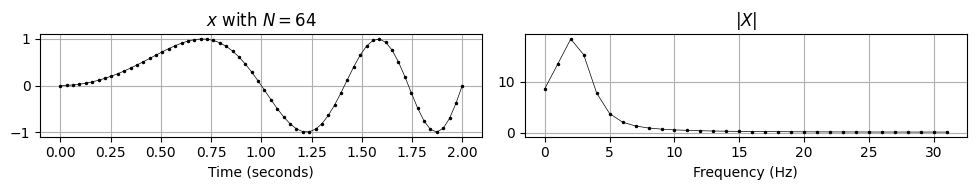

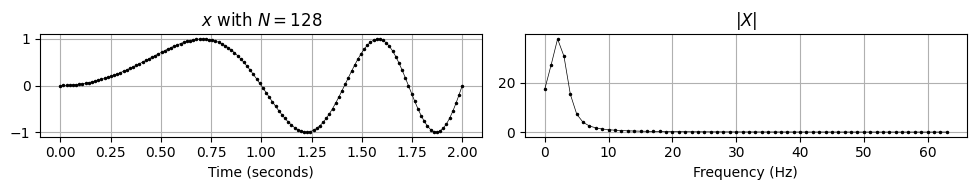

In [47]:
def generate_chirp(t0: float = 0, t1: float = 2, N: int = 256):
    assert 0 <= t0 < t1
    Fs = N / (t1 - t0)
    t = np.linspace(t0, t1, num=N)
    x = np.sin(np.pi * (t ** 2))
    return x, t

print("changes from t0")
for tt0 in [0, 0.5, 1]:
    print("case t0={}".format(tt0))
    x, t = generate_chirp(t0=tt0)
    X_hat = dft(x)
    plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True, freq_half=True)

print("changes from t1")
for tt1 in [2, 8, 32]:
    print("case t1={}".format(tt1))
    x, t = generate_chirp(t1=tt1)
    X_hat = dft(x)
    plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True, freq_half=True)

print("changes from N")
for n in [32, 64, 128]:
    x, t = generate_chirp(N=n)
    X_hat = dft(x)
    plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True, freq_half=True)

changes all together


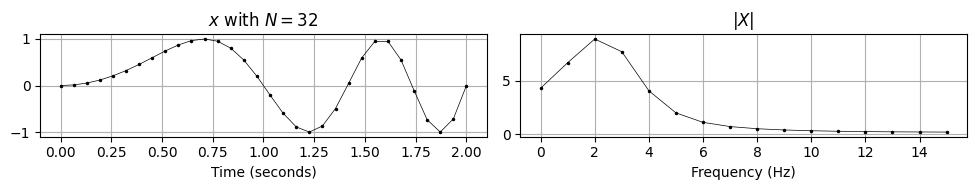

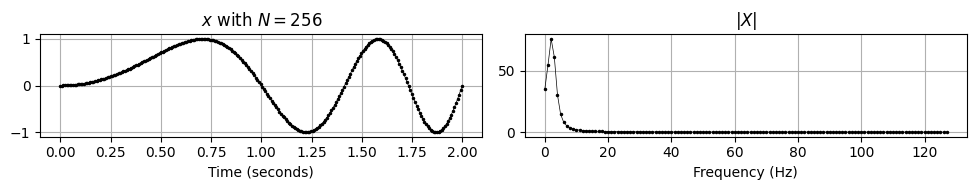

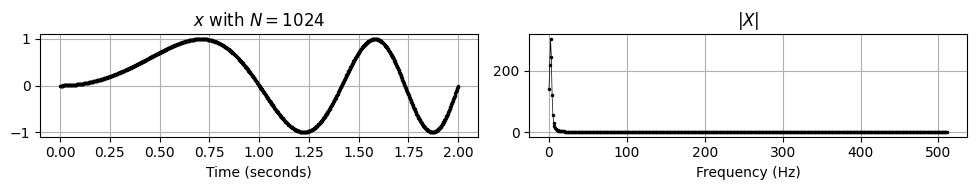

In [48]:
print("changes all together")
for tt1, n in ([2, 32], [8, 256], [32, 1024]):
    x, t = generate_chirp(N=n)
    X_hat = dft(x)
    plot_signal_dft(t, x, X_hat, ax_sec=True, ax_Hz=True, freq_half=True)

<a id='exercise_inverse'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 4: Inverse DFT</strong><br>

The discrete Fourier transform given by the matrix $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ is an invertible operation, given by the inverse DFT matrix $\mathrm{DFT}_N^{-1}$. 

- There is an explicit relation between $\mathrm{DFT}_N$ and its inverse $\mathrm{DFT}_N^{-1}$. Which one?
- Write a function <code>generate_matrix_dft_inv</code> that explicitly generates $\mathrm{DFT}_N^{-1}$. 
- Check your function by computing $\mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}$ and $\mathrm{DFT}_N^{-1} \cdot \mathrm{DFT}_N$ (using <code>np.matmul</code>) and comparing these products with the identity matrix (using <code>np.eye</code> and <code>np.allclose</code>).
- Furthermore, compute the inverse DFT by using <code>np.linalg.inv</code>. Compare the result with your function using <code>np.allclose</code>.
- Similar to <code>fft</code>, implement a fast inverse Fourier transform <code>fft_inv</code>